In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
import csv
import pickle
from glob import glob
from read_roi import read_roi_file, read_roi_zip
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def read_spike_complexity(names, path_rois, path_spikes):
    epochs = ['_baseline', '_early', '_pre']
    all_spikes = {}
    for e in names:
        for f in epochs:
            n = read_roi(path_rois, e + f )
            spike = open(path_spikes + e + f + "_spikes_complexity.csv", "r")
            reader_spike = csv.reader(spike)
            spikes = np.zeros((n,8000))
            for i,line in enumerate(reader_spike):
                for j in range(len(line)):
                    spikes[i][j] = line[j]
            all_spikes[e+f] = spikes
            
    return(all_spikes)

def read_roi(path, subject_roi):
    
    roi = read_roi_zip(glob(path + subject_roi +'.zip')[0])
    n = len(roi)
    
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-5,5)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def raster_plot(spikes, ax, s = 500, epochs = True): #plots the raster plot of the spike activity on a given axis 

        #be careful that neurons in different epochs are ordered differently
        n,t = spikes.shape
        
        #cmap = plt.cm.Spectral
        #norm = plt.Normalize(vmin = 0, vmax = float(np.max(spikes)))
        
        for i in range(n):
            for j in range(t):
                if spikes[i][j] == 0: pass
                else:
                    ax.scatter(j, i, s = 5, c = 'b', marker = 'x')#, norm = norm, cmap = cmap)
                    ax.set_title('Spike Raster Plot', fontsize = 20)
                    ax.set_xlabel('Time (Frames)', fontsize = 15)
                    ax.set_ylabel('Neuron ID', fontsize = 15)
                    ax.set_xticks([s*i for i in range(int(t/s)+1)])
                    ax.set_yticks([5*i for i in range(int(n/5)+1)]+[n])
                    ax.tick_params(axis = 'x', labelsize = 10)
                    ax.tick_params(axis = 'y', labelsize = 13)
        if epochs:pass
        else:ax.vlines([0,8000,16000],0,n+1, color = 'r')
                        
def concatenate(spikes, names): # concatanes the spike complexities of three epochs (baseline, early, pre) 
    #into single matrix. Some subjects have different number of ROIS in different epochs, so we just add zero rows
    ## to cover up that difference. 
    epochs = ['_baseline', '_early', '_pre']
    all_concatenated = {}
    for e in names:
        size = 0
        for i,f in enumerate(epochs):
            if spikes[e+f].shape[0] > size:
                size = spikes[e+f].shape[0]
        concatenated = np.zeros((size, 3*spikes[e+f].shape[1]))
        for i,f in enumerate(epochs):
            concatenated[0:spikes[e+f].shape[0],i*spikes[e+f].shape[1]:(i+1)*spikes[e+f].shape[1]] = spikes[e+f]
        all_concatenated[e] = concatenated
    return(all_concatenated)
    

def find_bin_size(array, spike_per_layer):
    
    array = bin_time_series(array, 500, array.shape[1])
    n, t, l = array.shape
    fouls = []
    
    for i in range(n):
        for j in range(l):
            if len(np.nonzero(array[i,:,j])[0]) < spike_per_layer:
                fouls.append('neuron %d in layer %d doesnt have enough spikes'%(i,j))
                
    return(fouls)

In [26]:
spikerates = [3, 15, 40] # provide it in an increasing order
time = 2000.0# in miliseconds
n_master_neurons = 3
binsize = 200
n_common_spikes = 5

In [35]:
master_spikes = []
for i in range(n_master_neurons):   
    master_spikes.append(homogeneous_poisson_process(rate = spikerates[i]*Hz, t_start = 0.0*ms, t_stop = time*ms, as_array=True))
master_spikes[:-1]

[array([  37.28290313,  320.69702223, 1341.99162726, 1346.78791475,
        1542.95429219, 1681.25976429, 1962.46902397]),
 array([  75.12799549,  109.3609539 ,  115.66229094,  254.62459353,
         339.14777332,  486.82006283,  488.90283572,  497.90864524,
         594.65693837,  670.84169416,  685.78575788,  705.46466175,
         781.69027085,  925.45537374, 1001.72803082, 1049.97522375,
        1141.55964673, 1223.81049939, 1225.36986271, 1236.04719582,
        1245.97583422, 1256.70581379, 1284.51721677, 1328.90508072,
        1339.17360269, 1361.49545087, 1403.29989601, 1420.72318187,
        1698.77928286, 1732.9779212 , 1755.40092219, 1822.82693685,
        1826.27060183, 1866.99940109, 1983.14691671])]

In [36]:
common_spikes = [random.choice(master_spikes[-1]) for i in range(n_common_spikes)]
common_spikes

[1824.2297870633492,
 211.74258705683206,
 1479.8833720650673,
 172.162434576832,
 1011.5887831222226]

In [42]:
common_master_spikes = []
for i,e in enumerate(master_spikes[:-1]):
    common_master_spikes.append(np.append(master_spikes[i],common_spikes))
common_master_spikes.append(master_spikes[-1])
common_master_spikes

[array([  37.28290313,  320.69702223, 1341.99162726, 1346.78791475,
        1542.95429219, 1681.25976429, 1962.46902397, 1824.22978706,
         211.74258706, 1479.88337207,  172.16243458, 1011.58878312]),
 array([  75.12799549,  109.3609539 ,  115.66229094,  254.62459353,
         339.14777332,  486.82006283,  488.90283572,  497.90864524,
         594.65693837,  670.84169416,  685.78575788,  705.46466175,
         781.69027085,  925.45537374, 1001.72803082, 1049.97522375,
        1141.55964673, 1223.81049939, 1225.36986271, 1236.04719582,
        1245.97583422, 1256.70581379, 1284.51721677, 1328.90508072,
        1339.17360269, 1361.49545087, 1403.29989601, 1420.72318187,
        1698.77928286, 1732.9779212 , 1755.40092219, 1822.82693685,
        1826.27060183, 1866.99940109, 1983.14691671, 1824.22978706,
         211.74258706, 1479.88337207,  172.16243458, 1011.58878312]),
 array([   2.14214064,   56.66464725,   81.03465406,  169.11850521,
         172.16243458,  181.21180075,  198.2

In [50]:
master_spike_trains = []
for i,e in enumerate(common_master_spikes):
    spike_trains = np.zeros((1,int(time)))
    for j,f in enumerate(e):
        spike_trains[0][int(f)] = 1
    master_spike_trains.append(spike_trains)
master_spike_trains

[array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 1., ..., 0., 0., 0.]])]

In [63]:
commsizes = [3,23,4]
commindices = [0,3,26,30]
spike = []
for i,e in enumerate(commsizes):
    for j in range(e):
        spike.append(jitter(master_spike_trains[i]))
spikes = np.zeros((commindices[-1],int(time)))
for i in range(spikes.shape[0]):
    spikes[i] = spike[i][0].tolist()

## There are three communities of size 3, 23 and 4 which all have different firing rate 3, 15, 40 respectively. We selected 5 different time points(see common_spikes) that all the neurons fire together. Our goal is finding the the time windows that has maximized correlation.

Text(0.5, 0, 'TIME (in Miliseconds)')

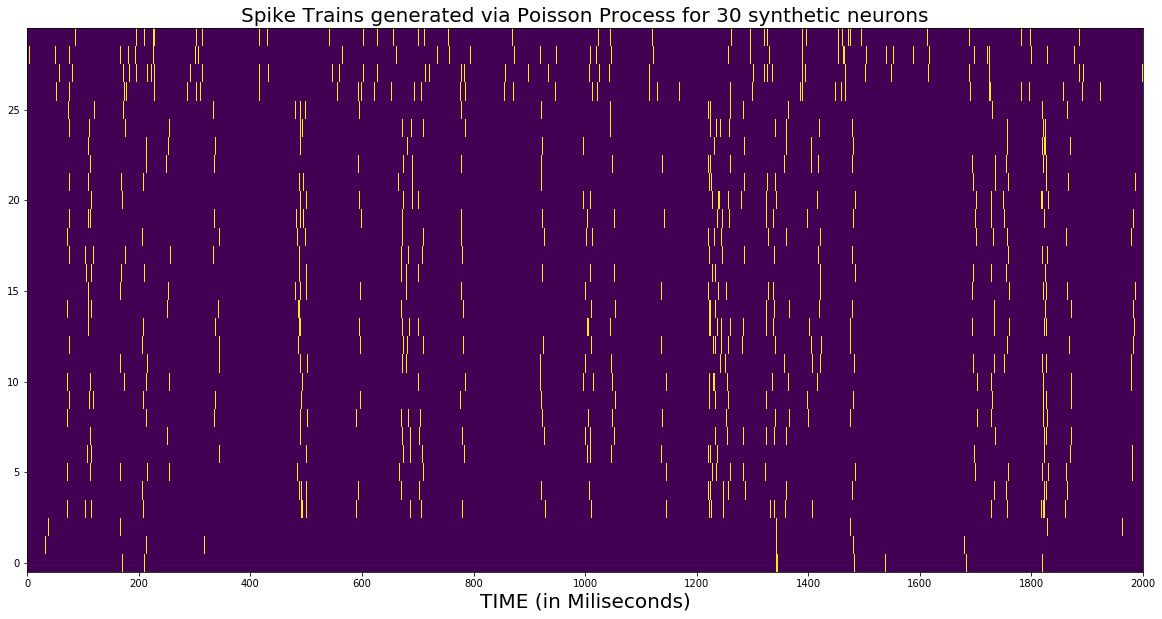

In [64]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'bottom left', interpolation='nearest', aspect='auto')
ax.set_title('Spike Trains generated via Poisson Process for 30 synthetic neurons', fontsize= 20)
ax.set_xticks([i*binsize for i in range(int(time/binsize))]+[time])
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)

In [70]:
standard_deviation = 1.25
gauss_spikes = np.zeros(spikes.shape)
for i in range(spikes.shape[0]):
    gauss_spikes[i] = gaussian_filter(spikes[i],standard_deviation)

Text(0.5, 0, 'TIME (in Miliseconds)')

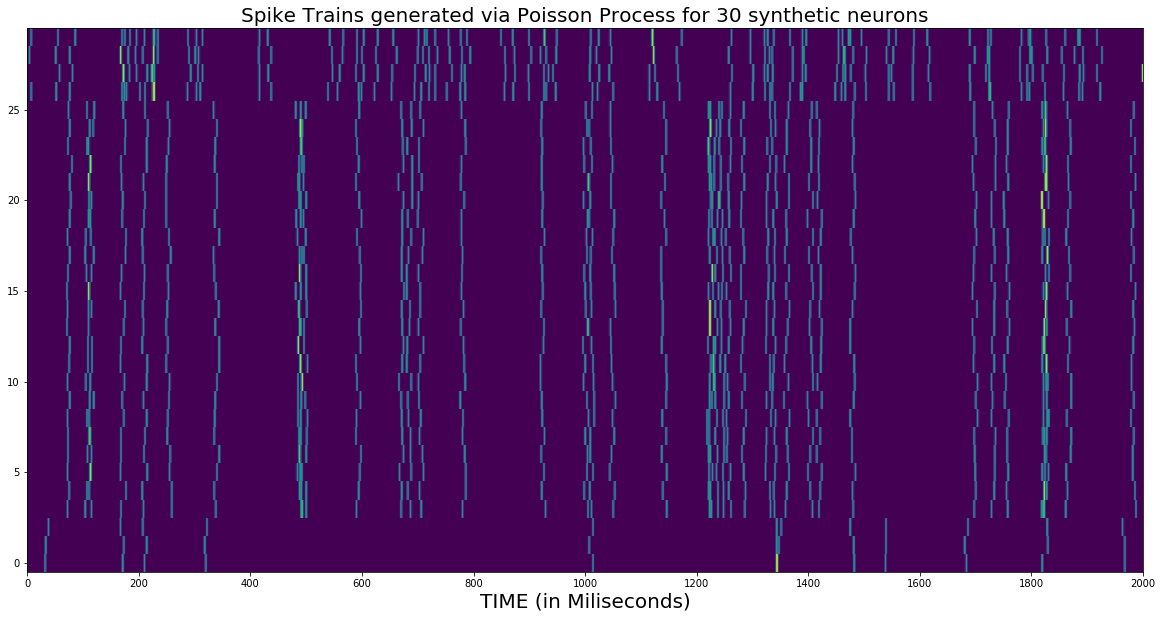

In [71]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(gauss_spikes, origin = 'bottom left', interpolation='nearest', aspect='auto')
ax.set_title('Spike Trains generated via Poisson Process for 30 synthetic neurons', fontsize= 20)
ax.set_xticks([i*binsize for i in range(int(time/binsize))]+[time])
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)

In [76]:
window_sizes = [10, 20, 50, 

In [81]:
adjacency_matrices = {}
adjacency_matrices['%d'%window_size]= [cross_correlation_matrix(gauss_spikes[:,i:window_size+i])[0] for i in range(int(time)-window_size):
                                       

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(M, origin = 'bottom left', interpolation='nearest', aspect='auto')